# CCD spectrometer
* ## Calibration
* ## Detection probability of polarized light -> Correction factor
* ## Laser
* ## Notch Filter  

Errors are taken to be the statistical ones: $s_N = \frac{\sqrt{N}}{\sqrt{n}}$, where N is the number of counts and n the number of measurements that have been measured over.

The xlim for plotting is set globally.

# Spectra

## Background

## CS$_2$: 
* ### Fit lines
* ### Recover $\Delta \nu$ for each line

## CHCl$_3$: 
* ### Fit lines
* ### Recover $\Delta \nu$ for each line

## CCL$_4$: 
* ### Fit lines
* ### Ratio of intensities parallely and perpendicularly polarized equals degree of polarization $\rho_s$.

## Ethanol
* Get data
* Remove outliers (errors from CCD)
* Fit flourescence for lambda > 550 nm with 3rd degree polynome, omitting the peaks
* Fit peaks on data - flourescence 

## Sulfur -- Temperature: 
* ### Fit one Stokes and the corresponding Anti-Stokes peak, 
* ### calculate ratio of intensities for different laser intensities, 
* ### determine temperature of probe.


Peak intensities are saved to 'As' (A = integral over breit_wigner). Only the single peaks are used. The double peak could be used for higher concentrations (>= 40% ethanol), but fits dont converge for lower ones. 
Luckily, the intensities do seem to make sense (although flourescence indicates something different - the latter may be a result of impurities in the original sample). 



All counts are transformed to rates. 

Background is then subtracted, polarization is assumed to be horizontally (0 deg) 
and corrected for the corresponding term.

Errors are taken to be the statistical ones: $s_N = \frac{\sqrt{N}}{\sqrt{n}}$, where N is the number of counts and n the number of measurements that have been measured over.

The xlim for plotting is set globally.


In [1]:
# %load ../../style.py
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import colorConverter
from matplotlib import rcParams
import seaborn as sns
from scipy.optimize import curve_fit
sns.set(style='ticks', palette='Set2') 
sns.despine()

fontsize_labels = 26    # size used in latex document
rcParams['text.latex.preamble'] = [r'\usepackage[cmbright]{sfmath}']
rcParams['font.family']= 'sans-serif'
rcParams['font.sans-serif']= 'cmbright'
rcParams['font.weight'] = "light"

rcParams['text.usetex'] = True

rcParams['figure.autolayout'] = True
rcParams['font.size'] = fontsize_labels
rcParams['axes.labelsize'] = fontsize_labels
rcParams['xtick.labelsize'] = fontsize_labels
rcParams['ytick.labelsize'] = fontsize_labels
rcParams['legend.fontsize'] = fontsize_labels
rcParams['axes.titlesize'] = fontsize_labels
xfactor = 2
rcParams['figure.figsize'] = (xfactor*6.2, xfactor*3.83)  


In [2]:
import re
from scipy.constants import c,h,eV, pi
hceV = h * c / eV
find_number = lambda string: re.search("-?\\d+",string).group(0)

from smooth import savitzky_golay
import uncertainties as uc
import uncertainties.unumpy as un

plt.close("all")
show_fig = True
save_fig = True # see below
if not save_fig:
        rcParams['figure.figsize'] = (13, 8)  # in inches; width corresponds to \textwidth in latex document (golden ratio)

fig_dir = "./figures/"
npy_dir = "./npy/"

color_names = ['windows blue', "pale red", "faded green", "amber", 
          'dark green', 'dark fuchsia', 'browny orange', 
          'puke green', 'dark royal blue', 'dusty purple', 'red orange']
colors = sns.xkcd_palette(color_names)
        
xlim_global = (420, 620) # Full range
xlim_global2 = (500, 590) # interesting range

In [3]:
def breit_wigner(x, x0, gamma, amplitude, offset):
    """
    Breit-Wigner or Cauchy distribution with location parameter x0 
    and scale parameter gamma = 0.5 * FWHM. Amplitude: 1 / (Pi * gamma). 
    No mean, variance or higher moments exist.
    """
    return amplitude / ((pi*gamma) * (1 + ((x - x0) / gamma)**2)) + offset
   
def bw_fit(x, y_e, x_range, p0, fit=True):
    x_min, x_max = x_range
    mask = (x > x_min) * (x < x_max)
    x_fit = x[mask]
    y_fit = un.nominal_values(y_e[mask])
    y_sigma = np.sqrt(un.std_devs(y_e[mask]))
    
    if fit:
        coeff, cov = curve_fit(breit_wigner, x_fit, y_fit, p0=p0, 
                                  sigma=y_sigma, absolute_sigma=True)
        c = uc.correlated_values(coeff, cov)
        fit_peak = breit_wigner(x_fit, *coeff)
    else:
        fit_peak = breit_wigner(x_fit, *p0)
        c = un.uarray(p0, [0, 0, 0, 0])
    
    return x_fit, fit_peak, c

def gauss(x, x0, sigma, amplitude, offset):
    """
    Gauss peak plus offset
    """
    return amplitude / (np.sqrt(2 * pi) * sigma) * np.exp(1)**(-(x - x0)**2 / (2 * sigma**2)) + offset
   
def gauss_fit(x, y_e, x_range, p0, fit=True):
    x_min, x_max = x_range
    mask = (x > x_min) * (x < x_max)
    x_fit = x[mask]
    y_fit = un.nominal_values(y_e[mask])
    y_sigma = np.sqrt(un.std_devs(y_e[mask]))
    
    if fit:
        coeff, cov = curve_fit(gauss, x_fit, y_fit, p0=p0, 
                                  sigma=y_sigma, absolute_sigma=True)
        c = uc.correlated_values(coeff, cov)
        fit_peak = gauss(x_fit, *coeff)
    else:
        fit_peak = gauss(x_fit, *p0)
        c = un.uarray(p0, [0, 0, 0, 0])
    
    return x_fit, fit_peak, c

def two_breit_wigner(x, x0, gamma, amplitude, x02, gamma2, amplitude2, offset):
    """
    Breit-Wigner or Cauchy distribution with location parameter x0 
    and scale parameter gamma = 0.5 * FWHM. Amplitude: 1 / (Pi * gamma). 
    No mean, variance or higher moments exist.
    """
    tbw = amplitude / ((np.pi*gamma) * (1 + ((x - x0) / gamma)**2)) + \
    amplitude2 / ((np.pi*gamma2) * (1 + ((x - x02) / gamma2)**2)) + offset
    return tbw

def two_bw_fit(x, y_e, x_range, p0, fit=True):
    x_min, x_max = x_range
    mask = (x > x_min) * (x < x_max)
    x_fit = x[mask]
    y_fit = un.nominal_values(y_e[mask])
    y_sigma = np.sqrt(un.std_devs(y_e[mask]))
    
    if fit:
        coeff, cov = curve_fit(two_breit_wigner, x_fit, y_fit, p0=p0, 
                                  sigma=y_sigma, absolute_sigma=True)
        c = uc.correlated_values(coeff, cov)
        fit_peak = two_breit_wigner(x_fit, *coeff)
    else:
        fit_peak = two_breit_wigner(x_fit, *p0)
        c = un.uarray(p0, [0, 0, 0, 0])
    
    return x_fit, fit_peak, c

def poly(x, p0, p1, p2, p3, p4):
    x_p = x - 540 # move x value near the points to be fitted in order to lower the error!
    return p0*x_p**4 + p1*x_p**3 + p2*x_p**2 + p3*x_p + p4

def poly_fit(x, y_e, x_range, p0):
    x_min, x_max = x_range
    mask = (x > x_min) * (x < x_max)
    x_fit = x[mask]
    y_fit = un.nominal_values(y_e[mask])
    y_sigma = np.sqrt(un.std_devs(y_e[mask]))

    coeff, cov = curve_fit(poly, x_fit, y_fit, p0=p0, 
                           sigma=y_sigma, absolute_sigma=True)
    c = uc.correlated_values(coeff, cov)
    return c

def linear(x, a, b):
    return (a*x + b)

In [4]:
# NOT SPECIFIC 

def uc_str(c, max_digit=4):
    """
    input format: uc.ufloat
    rounds float and corrisponding error to last significant digit
    returns float and error as string
    as integers with max max_digit (=4) error digits
    as floats with max 4 error digits
    as exp else
    """
    digit = -int(np.floor(np.log10(c.s)))    
    if (c.s * 10**digit) < 1.5: # convention...
        digit += 1
    c_r = round(c.n, digit)
    s_c_r = round(c.s, digit)
    if (-3 < digit) * (digit <= 0): # returns readable integers
        c_str = '%i \pm %i'%(c_r, s_c_r)
    elif (0 < digit) * (digit < (max_digit + 1)): # returns readable floats (max 3 digits)
        c_str = ('%.' + str(digit) + 'f \pm %.' + str(digit) + 'f')%(c_r, s_c_r)
    else: # returns exp
        c_str = ('(%.1f \pm %.1f)\mathrm{e}%i')%(c_r * 10**(digit-1), s_c_r * 10**(digit-1), -(digit-1))
    return c_str

def enum(arr1, *args):
    i_range = range(len(arr1))
    return zip(i_range, arr1 ,*args)

In [5]:
# RAMAN SPECIFIC
def t_avg(filename):
    """
    Get integration time and number of measurements
    """
    f = open("data/" + filename + ".txt", encoding='cp1252')
    lines = f.readlines()
    f.close()
    t = np.float(lines[8].split(' ')[2]) * 1e-6 # measured time in sec
    avg = np.float(lines[9].split(' ')[3]) # number of recording to take average from
    return t, avg

def lamb_to_cm(lamb_stokes):
    """
    Converts Raman peaks in nm into wavenumber (in cm^-1) of corresponding vibrational mode
    """
    #lamb_laser = 532 # nm, Nd:Yag frequency doubled
    lamb_laser = np.load(npy_dir + 'ccd_lamb_laser.npy')[0] # measured laser wavelength
    dnu_cm = abs(1 / lamb_laser - 1 / lamb_stokes) * 10**7
    return(dnu_cm)

def cm_to_lamb(dnu_cm):
    """
    Converts  wavenumber (in cm^-1) of vibrational mode into corresponding Stokes 
    peak in nm (for Nd:Yag laser)
    """
    #lamb_laser = 532 # nm, Nd:Yag frequency doubled
    lamb_laser = np.load(npy_dir + 'ccd_lamb_laser.npy')[0] # measured laser wavelength
    lamb_stokes = 1 / (1 / lamb_laser - dnu_cm * 10**-7) 
    lamb_anti_stokes =  1 / (1 / lamb_laser + dnu_cm * 10**-7) 
    return(lamb_stokes, lamb_anti_stokes)

def get_ccd_data(filename):
    t, avg = t_avg(filename)
    x = np.load("npy/"+filename+"_lamb.npy")
    y = np.load("npy/"+filename+"_count.npy")
    y_e = un.uarray(y, np.maximum(1, np.sqrt(y / avg)))
    return (t, avg, x, y, y_e)


def get_ccd_rate(filename):
    t, avg = t_avg(filename)
    x = np.load("npy/"+filename+"_lamb.npy")
    y = np.load("npy/"+filename+"_count.npy")
    y_e = un.uarray(y, np.maximum(1, np.sqrt(y / avg)))
    # transform to rates
    rate_bg = np.load(npy_dir + 'ccd_rate_bg.npy') # background rates
    rate_bg_e = np.load(npy_dir + 'ccd_rate_bg_e.npy')
    rate = y / t - rate_bg
    rate_e = y_e / t - rate_bg_e
    return (t, avg, x, rate, rate_e)

## Calibration

/usr/lib/python3/dist-packages/matplotlib/axes.py:4749: UserWarning: No labeled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labeled objects found. "
/usr/lib/python3/dist-packages/matplotlib/figure.py:372: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/usr/lib/python3/dist-packages/matplotlib/figure.py:1596: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


\cellcolor{LightCyan}$1$ & $(4354696.7 \pm 0.3)\mathrm{e}-4$ & $435.8$   \\
\cellcolor{LightCyan}$2$ & $(54589908.9 \pm 0.9)\mathrm{e}-5$ & $546.1$   \\
\cellcolor{LightCyan}$3$ & $(5767874.3 \pm 0.4)\mathrm{e}-4$ & $577.1$   \\
\cellcolor{LightCyan}$4$ & $(5788909.2 \pm 0.4)\mathrm{e}-4$ & $579.1$   \\


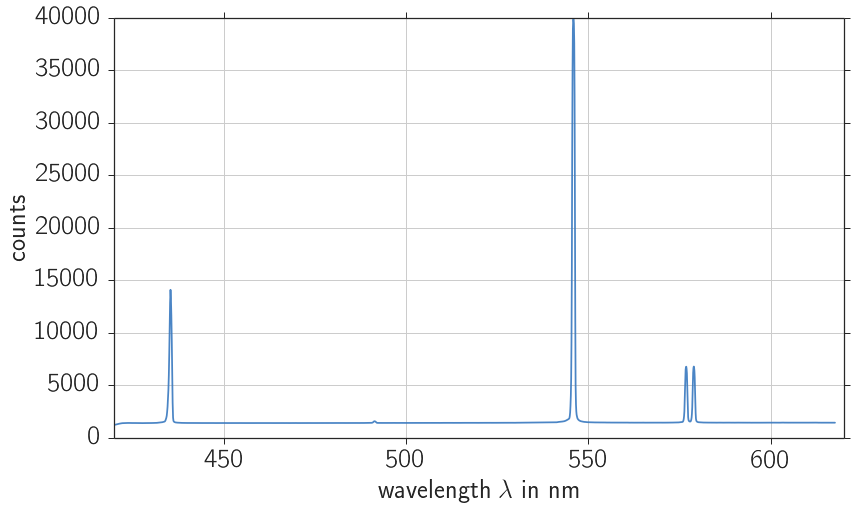

In [6]:
# Calibration

# Data
filename = "ccd_hg_00"
t, avg, x, y, y_e = get_ccd_data(filename)

As = []
x0s = []

# Plotting
fig, ax = plt.subplots(1,1)
if not save_fig:
    fig.suptitle('Calibration of CCD: Hg spectrum')
ax.plot(x, y, "-", c=colors[0], alpha = 0.9)

# Fit ranges and initial guesses
# p = [x0, gamma, amplitude, offset]
x_ranges = [[420, 450], [520, 560], [565, 578], [578, 585]]
p0s = np.array([[435, 0.2, 14000, 0], [545, 0.2, 40000, 0], 
               [577, 0.2, 5000, 0], [579, 0.2, 5000, 0]])
labels = ['435.8 nm', '546.1 nm', '577.1 nm', '579.1 nm']
for i, x_range, p0, label in enum(x_ranges, p0s, labels):
    x_fit, fit_peak, c1 = bw_fit(x, y_e, x_range, p0, fit=True)
    x0s.append(c1[0])
    As.append(c1[2])
ax.set_xlim(xlim_global)
ax.set_xlabel("wavelength $\lambda$ in nm")
ax.set_ylabel('counts')
ax.grid(True)
ax.legend(loc='best')
if show_fig:
    fig.show()
if save_fig:
    file_name = "ccd_calibration_hg"
    fig.savefig(fig_dir + file_name + ".pdf")
    fig.savefig(fig_dir + file_name + ".png")

# Print latex table
lits = [435.8, 546.1, 577.1, 579.1]
for i, x0, lit in enum(x0s, lits):
    print("\cellcolor{LightCyan}$%i$ & $%s$ & $%.1f$   \\\\"%(
            i+1, uc_str(x0), lit))

### Calibration: Linear fit

/usr/lib/python3/dist-packages/matplotlib/figure.py:372: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/usr/lib/python3/dist-packages/matplotlib/figure.py:1596: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


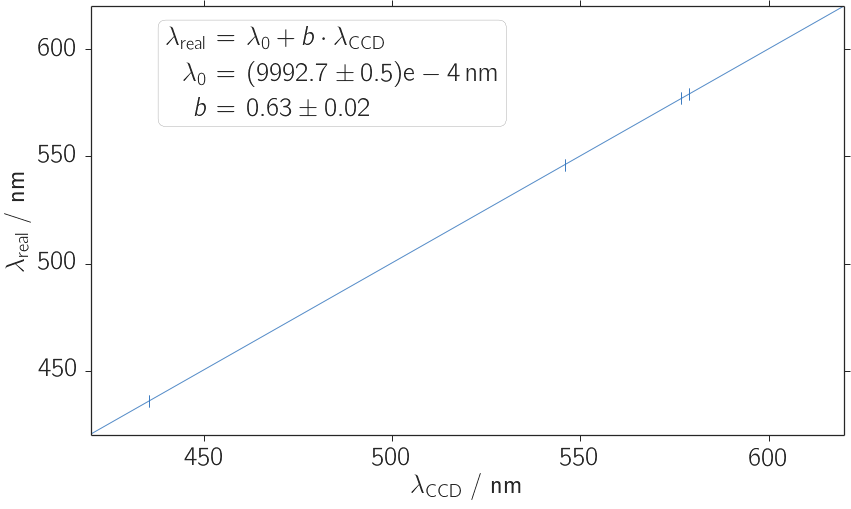

In [7]:
# Get all peaks. Use HWHM = gamma as error on peaks.
x0 = un.nominal_values(x0s)
s_x0 = un.std_devs(x0s)

lit_peaks = np.array([435.8, 546.1, 577.1, 579.1])
coeff_lin, cov_lin = curve_fit(linear, lit_peaks, x0, p0=None, 
                               sigma=np.sqrt(s_x0), absolute_sigma=True)
c_lin = uc.correlated_values(coeff_lin, cov_lin)

# Switch to lambda(x0) = lit_peak(x0)
d_lin = np.array([1 / c_lin[0], -c_lin[1] / c_lin[0]])
np.save(npy_dir + 'ccd_calibration', d_lin)

# Plotting
x_min, x_max = [420, 650]
x = np.linspace(x_min, x_max, 200)
fit = linear(x, *d_lin)

fig1, ax1 = plt.subplots(1, 1)
if not save_fig:
    fig1.suptitle('Calibration of CCD: Linear fit', y=1.02)
ax1.fill_between(x, 
        un.nominal_values(fit) + un.std_devs(fit),
        un.nominal_values(fit) - un.std_devs(fit),
        facecolor=colors[0], color=colors[0], alpha=0.2)
ax1.plot(x, un.nominal_values(fit), '-', c=colors[0], linewidth=1.0, alpha=0.8)  
ax1.errorbar(x0, lit_peaks, xerr=s_x0, yerr=None, fmt=',', c=colors[0], 
             elinewidth=1.0, capsize=6.2, capthick=0.8)
ax1.set_xlim(xlim_global)
ax1.set_ylim(xlim_global)
ax1.set_xlabel("$\lambda_\mathrm{CCD}$ / nm")
ax1.set_ylabel("$\lambda_\mathrm{real}$ / nm")

# Get the parameters ofthe linear fit to be presented in a textbox
l0_str = uc_str(d_lin[0])
b_str = uc_str(d_lin[1])
textstr = "\\begin{eqnarray*} \
        \\ \lambda_\mathrm{real} &=& \lambda_0 + b \cdot \lambda_\mathrm{CCD} \\\\ \
        \\ \lambda_0 &=& %s \,\mathrm{nm} \\\\ \
        \\ b &=& %s\
        \end{eqnarray*}"%(l0_str,b_str)
ax1 = plt.gca()
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax1.text(0.1, 0.95, textstr, transform=ax1.transAxes, va='top', bbox=props)

if show_fig:
    fig1.show()
if save_fig:
    file_name = "ccd_calibration_fit"
    fig1.savefig(fig_dir + file_name + ".pdf")
    fig1.savefig(fig_dir + file_name + ".png")

## Detection probability of polarized light

/usr/lib/python3/dist-packages/matplotlib/figure.py:372: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/usr/lib/python3/dist-packages/matplotlib/figure.py:1596: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


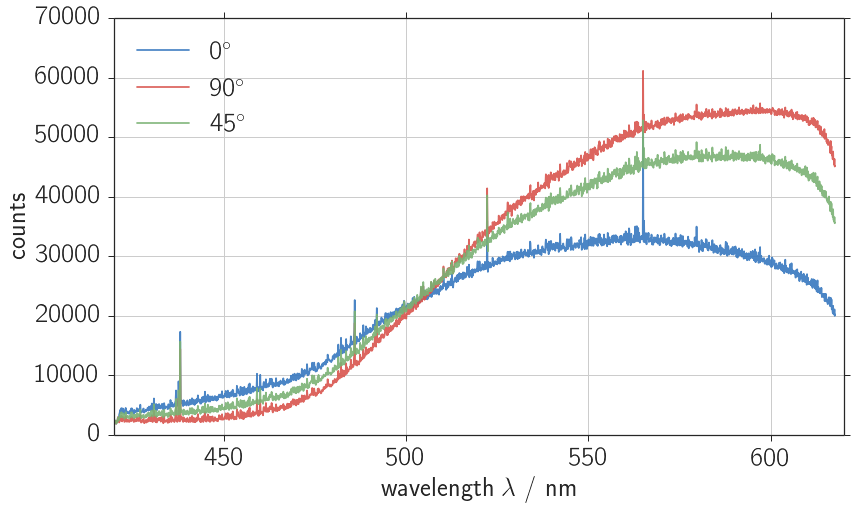

In [8]:
# Data
filename = "ccd_white_pol0"
t, avg, x, y0, y_e0 = get_ccd_data(filename)

filename = "ccd_white_pol45"
t, avg, x, y45, y_e45 = get_ccd_data(filename)

filename = "ccd_white_pol90"
t, avg, x, y90, y_e90 = get_ccd_data(filename)


# Plotting
fig, ax = plt.subplots(1,1)
if not save_fig:
    fig.suptitle('CCD: detection probability for polarized light')
ax.plot(x, y0, "-", alpha = 0.9, c=colors[0], label='$0^\circ$')
ax.plot(x, y90, "-", alpha = 0.9, c=colors[1], label='$90^\circ$')
ax.plot(x, y45, "-", alpha = 0.9, c=colors[2], label='$45^\circ$')
ax.set_xlim(xlim_global)
ax.set_xlabel("wavelength $\lambda$ / nm")
ax.set_ylabel("counts")
ax.grid(True)
ax.legend(loc='best')
if show_fig:
    fig.show()
if save_fig:
    file_name = "ccd_polarized"
    fig.savefig(fig_dir + file_name + ".pdf")
    fig.savefig(fig_dir + file_name + ".png")

### The measurement sensitivity is calculated by the ratio of measurements for $0^\circ$ and $90^\circ$ over those for  $45^\circ$.  In order to get corrections, one has to take the inverse. This neglects nonlinear effects...

/usr/lib/python3/dist-packages/matplotlib/figure.py:372: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/usr/lib/python3/dist-packages/matplotlib/figure.py:1596: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


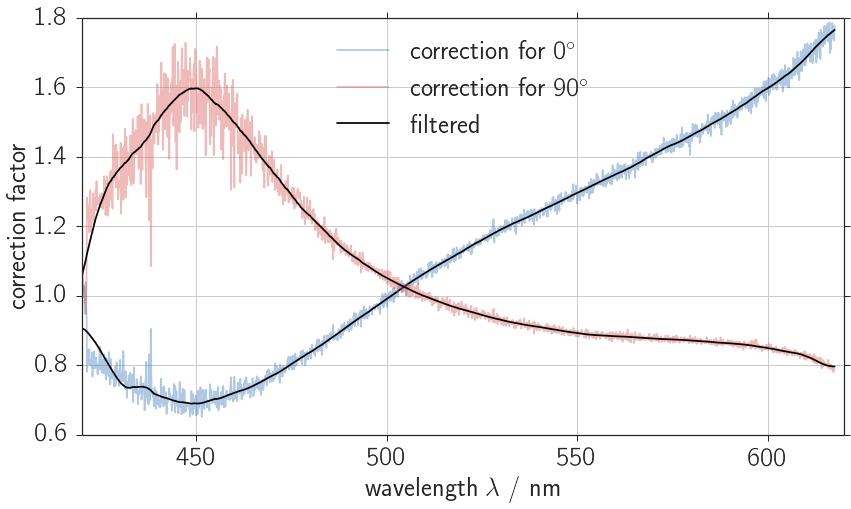

In [9]:
corr0  = y45 / y0
corr90 = y45 / y90

# remove one outlier:
mstep = np.argmin(corr0[1:] - corr0[:-1]) + 1 # find the outlier
n = 20
low = corr0[mstep - n: mstep]
up = corr0[mstep + 1: mstep + n + 1]
corr_avg = np.mean(low + up) / 2 
corr0[mstep] = corr_avg # replace it by the mean of the n values in both directions

n_sav = 301 # number of data point for savitzki-golay filter
corr0_fil = savitzky_golay(corr0, n_sav, 4)
corr90_fil = savitzky_golay(corr90, n_sav, 4)

np.save(npy_dir + 'ccd_corr0', corr0_fil)
np.save(npy_dir + 'ccd_corr90', corr90_fil)

# Plotting
fig, ax = plt.subplots(1,1)
if not save_fig:
    fig.suptitle('CCD: correction for polarization bias')
ax.plot(x, corr0,  "-", alpha = 0.4, c=colors[0], label='correction for $0^\circ$')
ax.plot(x, corr0_fil,  "k-", alpha = 0.99)
ax.plot(x, corr90, "-", alpha = 0.4, c=colors[1], label='correction for $90^\circ$')
ax.plot(x, corr90_fil, "k-", alpha = 0.99, label='filtered')
ax.set_xlim(xlim_global)
ax.set_xlabel("wavelength $\lambda$ / nm")
ax.set_ylabel("correction factor")
ax.grid(True)
ax.legend(loc='best')
if show_fig:
    fig.show()
if save_fig:
    file_name = "ccd_correction"
    fig.savefig(fig_dir + file_name + ".pdf")
    fig.savefig(fig_dir + file_name + ".png")

## Analysing the laser

/usr/lib/python3/dist-packages/matplotlib/figure.py:372: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/usr/lib/python3/dist-packages/matplotlib/figure.py:1596: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


532.1 \pm 0.3


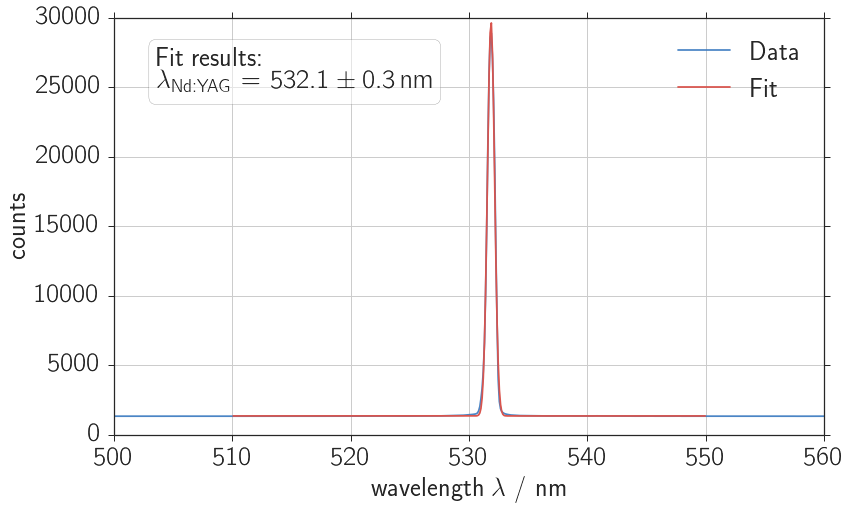

In [10]:
# Data
filename = "ccd_laser_ccl4_00"
t, avg, x, y, y_e = get_ccd_data(filename)

# Fitting
# p = [x0, sigma, amplitude, offset]
x_range = [510, 550]   # lower and upper bound
p0 = np.array([531, 0.4, 27000, 1420])
x_fit1, fit_peak1, c1 = gauss_fit(x, y_e, x_range, p0, fit=True)
x0 = uc.ufloat(c1[0].n, c1[1].n) # choose sigma as error on laser wavelength!
lamb_laser = linear(np.array([x0]), *d_lin) # Correct for calibration
np.save(npy_dir + 'ccd_lamb_laser', lamb_laser)
print(uc_str(lamb_laser[0]))

# Plotting
fig, ax = plt.subplots(1,1)
if not save_fig:
    fig.suptitle('CCD, Laser (Rayleigh peak for CCl$_4$)')
ax.plot(x, y, "-", alpha = 0.9, c=colors[0], label='Data')
ax.plot(x_fit1, fit_peak1, "-", c=colors[1], label='Fit')
ax.set_xlim(500, 560)
ax.set_xlabel("wavelength $\lambda$ / nm")
ax.set_ylabel("counts")
ax.grid(True)
ax.legend(loc='best')

# Get the parameters ofthe linear fit to be presented in a textbox
peak_str = uc_str(lamb_laser[0])
textstr = "Fit results:\n \
        \\begin{eqnarray*} \
        \\ \lambda_\mathrm{Nd:YAG} &=& %s \,\mathrm{nm} \\\\ \
        \end{eqnarray*}"%(peak_str)
ax1 = plt.gca()
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax1.text(0.06, 0.93, textstr, transform=ax1.transAxes, va='top', bbox=props)

if show_fig:
    fig.show()
if save_fig:
    file_name = "ccd_laser_peak"
    fig.savefig(fig_dir + file_name + ".pdf")
    fig.savefig(fig_dir + file_name + ".png")

## Notch filter

/usr/lib/python3/dist-packages/matplotlib/figure.py:372: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/usr/lib/python3/dist-packages/matplotlib/figure.py:1596: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


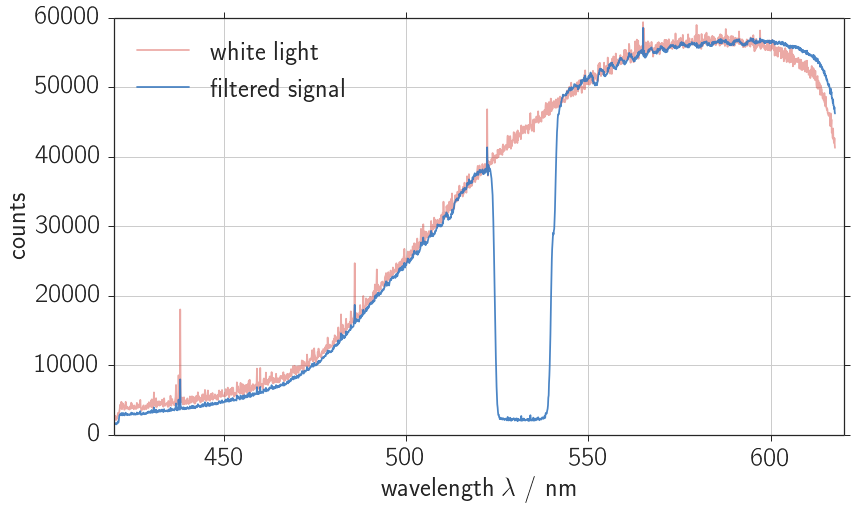

In [11]:
# Data
filename = "ccd_white_notch"
t, avg, x_notch, y, y_e = get_ccd_data(filename)

# White background
y_white = np.load("npy/ccd_white_00_count.npy")
notch = y_white * 1.12 - y
np.save(npy_dir + 'ccd_notch', notch)
np.save(npy_dir + 'ccd_x_notch', x_notch)

# Plotting
fig, ax = plt.subplots(1,1)
if not save_fig:
    fig.suptitle('Notch filter, background: white light')
ax.plot(x_notch, y_white * 1.12, "-", c=colors[1], alpha = 0.5, label='white light')
ax.plot(x_notch, y, "-", c=colors[0], alpha = 0.9, label='filtered signal')
ax.set_xlim(xlim_global)
#ax.set_xlim(510, 550) # a closer look!
ax.set_xlabel("wavelength $\lambda$ / nm")
ax.set_ylabel("counts")
ax.grid(True)
ax.legend(loc='best')
if show_fig:
    fig.show()
if save_fig:
    file_name = "ccd_notch_filter"
    fig.savefig(fig_dir + file_name + ".pdf")
    fig.savefig(fig_dir + file_name + ".png")

## Background

/usr/lib/python3/dist-packages/matplotlib/figure.py:372: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/usr/lib/python3/dist-packages/matplotlib/figure.py:1596: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


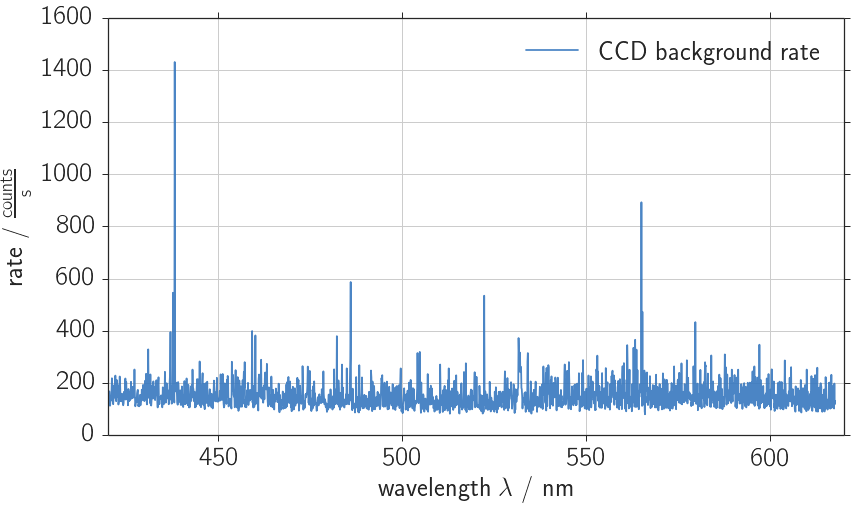

In [12]:
#### Background ####

# Data
filename = "ccd_bg_30_10"
t, avg, x, y, y_e = get_ccd_data(filename)

rate_bg = y / t
rate_bg_e = y_e / t
np.save(npy_dir + 'ccd_rate_bg', rate_bg)
np.save(npy_dir + 'ccd_rate_bg_e', rate_bg_e)

# Plotting
fig, ax = plt.subplots(1,1)
if not save_fig:
    fig.suptitle('CCD background')
ax.plot(x, rate_bg, "-", alpha = 0.9, c=colors[0], label='CCD background rate')
ax.set_xlim(xlim_global)
ax.set_xlabel('wavelength $\lambda$ / nm')
ax.set_ylabel('rate / $\mathrm{\\frac{counts}{s}}$')
ax.grid(True)
ax.legend(loc='best')
if show_fig:
    fig.show()
if save_fig:
    file_name = "ccd_background"
    fig.savefig(fig_dir + file_name + ".pdf")
    fig.savefig(fig_dir + file_name + ".png")

## CS$_2$: 
* ### Fit lines
* ### Recover $\Delta \nu$ for each line

\cellcolor{LightCyan}$1$ & $514.256 \pm 0.003$ & $652 \pm 11$ & $658$   \\
\cellcolor{LightCyan}$2$ & $551.232 \pm 0.002$ & $652 \pm 11$ & $658$   \\
\cellcolor{LightCyan}$3$ & $555.716 \pm 0.003$ & $799 \pm 11$ & $?$   \\


/usr/lib/python3/dist-packages/matplotlib/figure.py:1596: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


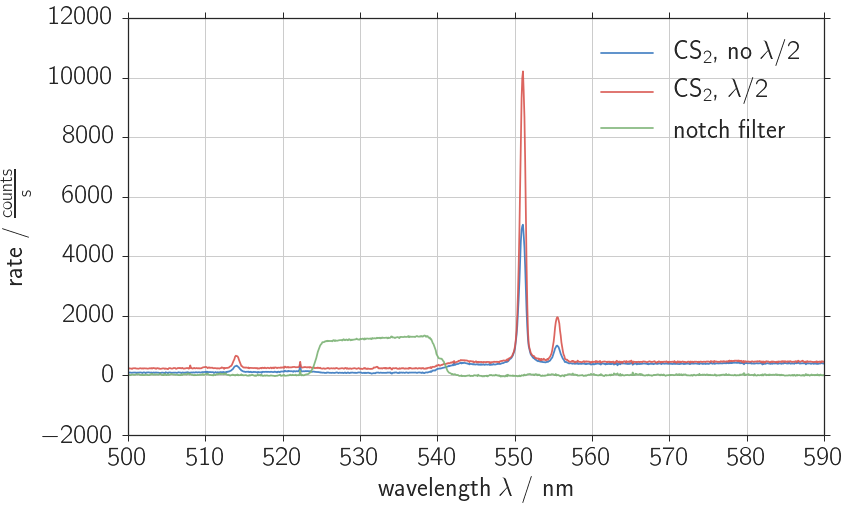

In [13]:
# CS$_2$

As = []
x0s = []
suffixes = ['_notch', '_notch_l2']
labels = ['CS$_2$, no $\lambda / 2$', 'CS$_2$, $\lambda / 2$']

# Plotting
fig, ax = plt.subplots(1,1)
if not save_fig: 
    fig.suptitle('CCD: CS$_2$ spectrum')   
for i, suffix, label in enum(suffixes, labels):
    filename = "ccd_cs2" + suffix
    t, avg, x, y, y_e = get_ccd_rate(filename)

    # Remove outliers 
    # identified by largest absolute value of difference between point and its two neighbours.
    for j in range(1):
        out = np.argmax(abs(2 * y[1:-1] - y[:-2] - y[2:])) + 1
        x, y = np.delete([x, y], out, 1)
        y_e = np.delete(y_e, out)
    ax.plot(x, y, "-", alpha = 0.9, c=colors[i], label=label)
    
    # Peak fit
    # Peaks: Stokes 2,3, Anti-Stokes 2
    x_ranges = [[544, 553],
                [553, 560], 
                [512, 517]]
    p0s = np.array([[551, 0.2, 10000, 0],
                    [555, 0.2, 2000, 0], 
                    [514, 0.2, 200, 0]])
    for x_range, p0 in zip(x_ranges, p0s):
        x_fit, fit_peak, c1 = bw_fit(x, y_e, x_range, p0, fit=True)
        #ax.plot(x_fit, fit_peak, "--", c=colors[i])
        x0s.append(c1[0])
        As.append(c1[2])

# display notch filter in order to identify its effects
x_notch = np.load("npy/ccd_x_notch.npy")
notch = np.load("npy/ccd_notch.npy")
ax.plot(x_notch, notch*0.03, "-", c=colors[2], alpha = 0.9, label='notch filter')

ax.set_xlim(xlim_global2)
ax.set_xlabel('wavelength $\lambda$ / nm')
ax.set_ylabel('rate / $\mathrm{\\frac{counts}{s}}$')
ax.grid(True)
ax.legend(loc='best')

if save_fig:
    file_name = "ccd_cs2_spectra"
    fig.savefig(fig_dir + file_name + ".pdf")
    fig.savefig(fig_dir + file_name + ".png")
    
    
# Print Latex table
lamb_all = np.array(x0s).reshape(2, 3)

d_lin = np.load(npy_dir + 'ccd_calibration.npy') 
lamb_all = linear(lamb_all, *d_lin) # Integrate error on wavelength of CCD

lamb_mean = np.sort(np.mean(lamb_all, 0)) 
lamb_laser = np.load(npy_dir + 'ccd_lamb_laser.npy')[0]

dnu = (1 / lamb_mean - 1 / lamb_laser) * 10**7

lits = np.array(['658', '658', '?']) # S, S, AS for CS2

for i, x0, dnu_cm, lit in enum(lamb_mean, lamb_to_cm(lamb_mean), lits):
    print("\cellcolor{LightCyan}$%i$ & $%s$ & $%s$ & $%s$   \\\\"%(
            i+1, uc_str(x0), uc_str(dnu_cm), lit))

\cellcolor{LightCyan}$1$ & $511.4 \pm 0.8$ & $760 \pm 30$ & $774$   \\
\cellcolor{LightCyan}$2$ & $513.8 \pm 0.3$ & $670 \pm 20$ & $680$   \\
\cellcolor{LightCyan}$3$ & $522.0 \pm 0.4$ & $370 \pm 20$ & $366$   \\
\cellcolor{LightCyan}$4$ & $542.6 \pm 0.3$ & $365 \pm 15$ & $366$   \\
\cellcolor{LightCyan}$5$ & $551.7 \pm 0.3$ & $667 \pm 15$ & $680$   \\
\cellcolor{LightCyan}$6$ & $554.5 \pm 0.7$ & $760 \pm 20$ & $774$   \\
\cellcolor{LightCyan}$7$ & $568.9 \pm 0.5$ & $1210 \pm 20$ & $1220$   \\


/usr/lib/python3/dist-packages/matplotlib/figure.py:1596: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


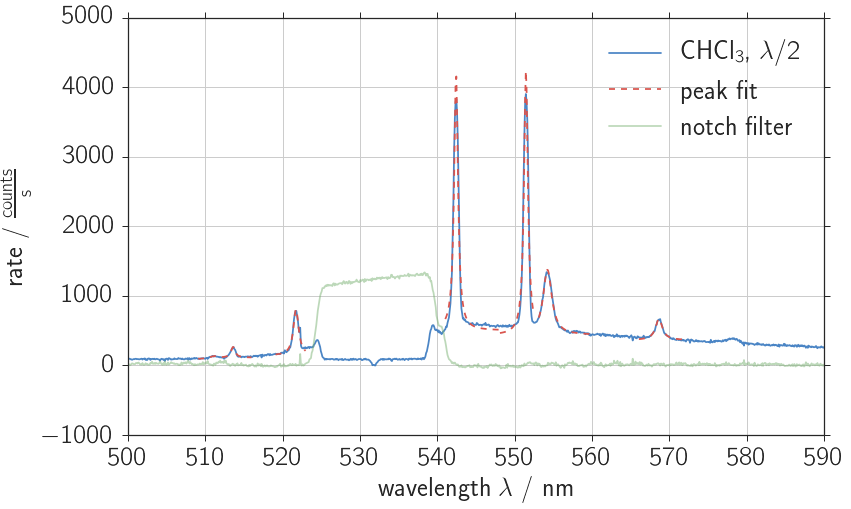

In [14]:
# CHCl$_3$

As = []
x0s = []
suffixes = ['_notch_l2'] # peaks not visible for data without l2 plate
labels = ['CHCl$_3$, $\lambda / 2$']

# Plotting
fig, ax = plt.subplots(1,1)
if not save_fig: 
    fig.suptitle('CCD: CHCl$_3$ spectrum')
for i, suffix, label in enum(suffixes, labels):
    filename = "ccd_chcl3" + suffix
    t, avg, x, y, y_e = get_ccd_rate(filename)

    # Remove outliers 
    # identified by largest absolute value of difference between point and its two neighbours.
    for j in range(2):
        out = np.argmax(abs(2 * y[1:-1] - y[:-2] - y[2:])) + 1
        x, y = np.delete([x, y], out, 1)
        y_e = np.delete(y_e, out)
    ax.plot(x, y, "-", alpha = 0.9, c=colors[i], label=label)
   
    # Peak fit
    # Peaks: Stokes 1 - 4, Anti-Stokes 1, 2
    x_ranges = [[541, 548],
                [548, 552.5], 
                [553, 560], 
                [566, 572], 
                [519, 523], 
                [512, 516], 
                [509, 512]]
    p0s = np.array([[543, 0.2, 2000, 600],
                    [551.5, 0.2, 2000, 600], 
                    [554, 0.4, 700, 600], 
                    [569, 0.3, 700, 600], 
                    [522, 0.3, 1000, 100], 
                    [514, 0.3, 1000, 100], 
                    [511, 0.3, 100, 100]])
    for j, x_range, p0 in enum(x_ranges, p0s):
        x_fit, fit_peak, c1 = bw_fit(x, y_e, x_range, p0, fit=True)
        if j==0:
            ax.plot(x_fit, fit_peak, "--", c=colors[i+1], label='peak fit')
        else:
            ax.plot(x_fit, fit_peak, "--", c=colors[i+1])
        x0s.append(uc.ufloat(c1[0].n, c1[1].n))
        As.append(c1[2])

# display notch filter in order to identify its effects
x_notch = np.load("npy/ccd_x_notch.npy")
notch = np.load("npy/ccd_notch.npy")
ax.plot(x_notch, notch*0.03, "-", c=colors[2], alpha = 0.5, label='notch filter')

ax.set_xlim(xlim_global2)
ax.set_xlim(500, 590)
ax.set_xlabel('wavelength $\lambda$ / nm')
ax.set_ylabel('rate / $\mathrm{\\frac{counts}{s}}$')
ax.grid(True)
ax.legend(loc='best')

if save_fig:
    file_name = "ccd_chcl3_spectra"
    fig.savefig(fig_dir + file_name + ".pdf")
    fig.savefig(fig_dir + file_name + ".png")
    
# Print Latex table
lamb_all = np.sort(np.array(x0s))
d_lin = np.load(npy_dir + 'ccd_calibration.npy') 
lamb_all = linear(lamb_all, *d_lin) # Integrate error on wavelength of CCD
lamb_laser = np.load(npy_dir + 'ccd_lamb_laser.npy')[0]

dnu = (1 / lamb_all - 1 / lamb_laser) * 10**7 # in cm^-1

lits = np.array([774, 680, 366, 366, 680, 774, 1220]) # S, S, AS for CS2

for i, x0, dnu_cm, lit in enum(lamb_all, lamb_to_cm(lamb_all), lits):
    print("\cellcolor{LightCyan}$%i$ & $%s$ & $%s$ & $%i$   \\\\"%(
            i+1, uc_str(x0), uc_str(dnu_cm), lit))

## CCl4
* Get data for different polarizations of laser (w/ or w/out $\lambda$/2 plate)
* Notch filter is plotted in order to see its influence.
* Fit five peaks: 3 Stokes, 2 Antistokes

\cellcolor{LightCyan}$1$ & $511.2 \pm 0.5$ & $770 \pm 20$ & $776$   \\
\cellcolor{LightCyan}$2$ & $519.5 \pm 0.3$ & $460 \pm 20$ & $459$   \\
\cellcolor{LightCyan}$3$ & $523.4 \pm 0.3$ & $312 \pm 15$ & $314$   \\
\cellcolor{LightCyan}$4$ & $541.2 \pm 0.3$ & $315 \pm 14$ & $314$   \\
\cellcolor{LightCyan}$5$ & $545.4 \pm 0.3$ & $459 \pm 14$ & $459$   \\
\cellcolor{LightCyan}$6$ & $555.0 \pm 0.6$ & $780 \pm 20$ & $776$   \\
\cellcolor{LightCyan}$7$ & $579.4 \pm 0.9$ & $1530 \pm 30$ & $?$   \\

 Depolarization
\cellcolor{LightCyan}$1$ & $776$ & $24 \pm 2$ & $27 \pm 2$ & $0.89 \pm 0.09$ & $0.76$ \\
\cellcolor{LightCyan}$2$ & $459$ & $123.2 \pm 1.3$ & $429.9 \pm 1.2$ & $0.287 \pm 0.003$ & $0.03$ \\
\cellcolor{LightCyan}$3$ & $314$ & $290.8 \pm 1.3$ & $335.5 \pm 1.2$ & $0.867 \pm 0.005$ & $0.71$ \\
\cellcolor{LightCyan}$4$ & $314$ & $896.6 \pm 1.4$ & $1040.5 \pm 1.3$ & $0.862 \pm 0.002$ & $0.71$ \\
\cellcolor{LightCyan}$5$ & $459$ & $790.4 \pm 1.2$ & $2760.5 \pm 1.2$ & $0.2863 \pm 0.0005$ & 

/usr/lib/python3/dist-packages/matplotlib/figure.py:1596: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


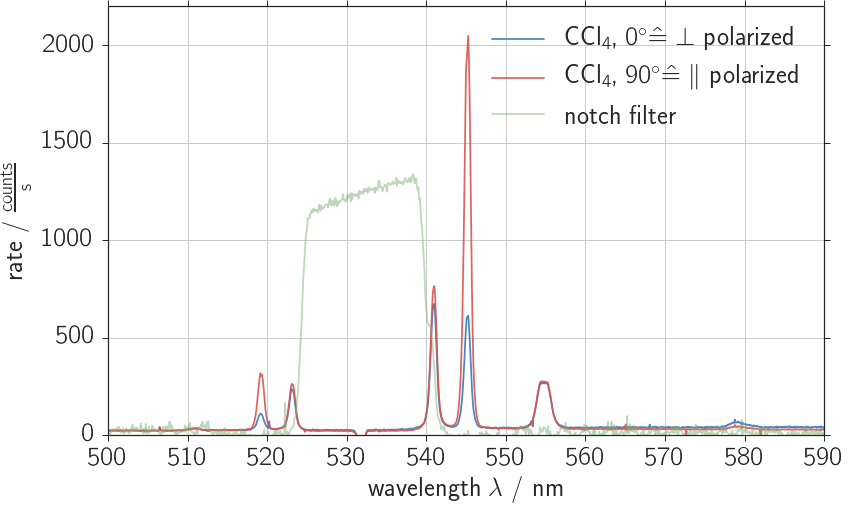

In [15]:
# CCl4

As = []
x0s = []
corr0 = np.load(npy_dir + 'ccd_corr0.npy') # Correction factor for polarization
corr90 = np.load(npy_dir + 'ccd_corr90.npy') # Correction factor for polarization
suffixes = ['l2_pol0', 'l2_pol90']
labels = ['CCl$_4$, $0^\circ \hat{=} \perp$ polarized', 'CCl$_4$, $90^\circ \hat{=} \parallel$ polarized']

# Plotting
fig, ax = plt.subplots(1,1)
if not save_fig:
    fig.suptitle('CCD: CCl4 spectrum')
for i, suffix, label in enum(suffixes, labels):
    filename = "ccd_ccl4_" + suffix
    t, avg, x, y, y_e = get_ccd_rate(filename)
    
    # Correction for polarization
    if suffix[-2:] == '90':
        corr = corr90
    else:
        corr = corr0
    y = corr * y
    y_e = corr * y_e  

    # Remove outliers 
    # identified by largest absolute value of difference between point and its two neighbours.
    for j in range(5):
        out = np.argmax(abs(2 * y[1:-1] - y[:-2] - y[2:])) + 1
        #print(x[out], y[out])
        x, y = np.delete([x, y], out, 1)
        y_e = np.delete(y_e, out)
    ax.plot(x, y, "-", alpha = 0.9, c=colors[i], label=label)

    # Peak fit
    # Peaks: Stokes 1 - 3, Anti-Stokes 1, 2
    x_ranges = [[537, 543],
                [544, 552],
                [548, 560], 
                [575, 585], 
                [520, 526],
                [514, 520], 
                [507, 516]]
    p0s = np.array([[541, 0.2, 1000, 0],
                    [546, 0.2, 2000, 0],
                    [555, 0.2, 400, 0], 
                    [579, 0.2, 60, 0], 
                    [523, 0.2, 200, 0],
                    [519, 0.2, 200, 0], 
                    [511, 0.2, 30, 0]])
    for x_range, p0 in zip(x_ranges, p0s):
        x_fit, fit_peak, c1 = bw_fit(x, y_e, x_range, p0, fit=True)
        #ax.plot(x_fit, fit_peak, "--", c=colors[i])
        x0s.append(uc.ufloat(c1[0].n, c1[1].n))
        As.append(c1[2])
    
# display notch filter in order to identify its effects
x_notch = np.load("npy/ccd_x_notch.npy")
notch = np.load("npy/ccd_notch.npy")
ax.plot(x_notch, notch * 0.03, "-", c=colors[2], alpha = 0.5, label='notch filter')

ax.set_xlim(xlim_global2)
ax.set_ylim(0, 2200)
ax.set_xlabel('wavelength $\lambda$ / nm')
ax.set_ylabel('rate / $\mathrm{\\frac{counts}{s}}$')
ax.grid(True)
ax.legend(loc='best')

if save_fig:
    file_name = "ccd_ccl4_spectra"
    fig.savefig(fig_dir + file_name + ".pdf")
    fig.savefig(fig_dir + file_name + ".png")
    
# Print results to latex tables
lamb_all = np.array(x0s).reshape(2, 7)
d_lin = np.load(npy_dir + 'ccd_calibration.npy') 
lamb_all = linear(lamb_all, *d_lin) # Integrate error on wavelength of CCD

lamb_mean = np.sort(np.mean(lamb_all, 0)) 
lamb_laser = np.load(npy_dir + 'ccd_lamb_laser.npy')[0]

dnu = (1 / lamb_mean - 1 / lamb_laser) * 10**7

lits = np.array(['776', '459', '314', '314', '459', '776', '?']) # S, S, S, AS, AS for CCl4

for i, x0, dnu_cm, lit in enum(lamb_mean, lamb_to_cm(lamb_mean), lits):
    print("\cellcolor{LightCyan}$%i$ & $%s$ & $%s$ & $%s$   \\\\"%(
            i+1, uc_str(x0), uc_str(dnu_cm), lit))

I_s = np.array(As).reshape(2, 7).T[[-1, -2, -3, 0, 1, 2, 3]].T

I_s = np.delete(I_s, -1, 1) # Remove the value of the unknown peak!

rhos = I_s[0] / I_s[1]
rho_lits = [0.76, 0.03, 0.71, 0.71, 0.03, 0.76]
print('\n Depolarization')
for i, lit, Iperp, Ipara, rho, rho_lit in enum(lits[:-1], I_s[0],  I_s[1], rhos, rho_lits):
    print("\cellcolor{LightCyan}$%i$ & $%s$ & $%s$ & $%s$ & $%s$ & $%.2f$ \\\\"%(
            i+1, lit, uc_str(Iperp), uc_str(Ipara), uc_str(rho) ,rho_lit))

Because of the notch filter, we cannot analyse the first two raman lines closer to the laser peak ($\Delta \nu = (218, 314)$ cm$^{-1}$). It is not quite clear what 0 or 90 degrees polarization is supposed to mean. 
Our interpretation is: 0 degrees corresponds to perpendicular polarization, 90 to parallel. 
The resulting degree of polarization for $\Delta \nu = 450$ cm$^{-1}$ (lit: 459) is much higher than the lit value (our: 0.29, lit: 0.02). Since this Raman line corresponds to a totally symmetric vibrational mode, one would even expect $\rho$ to be zero. 

Lit: 

https://books.google.de/books?id=PAoVdNiHUwEC&pg=SA3-PA51&dq=raman+spectroscopy+depolarization+ccl4&hl=en&sa=X&ei=PYIqVduMDsPfPYCEgdAM&redir_esc=y#v=onepage&q=raman%20spectroscopy%20depolarization%20ccl4&f=false

https://books.google.de/books?id=f_sJ8CGfetYC&pg=PA129&dq=raman+spectroscopy+depolarization+ccl4&hl=en&sa=X&ei=PYIqVduMDsPfPYCEgdAM&redir_esc=y#v=onepage&q=raman%20spectroscopy%20depolarization%20ccl4&f=false

Calculate ethanol
10% ethanol
20% ethanol
30% ethanol
40% ethanol
60% ethanol
70% ethanol
80% ethanol
100% ethanol
orig% ethanol


/usr/lib/python3/dist-packages/matplotlib/figure.py:1596: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


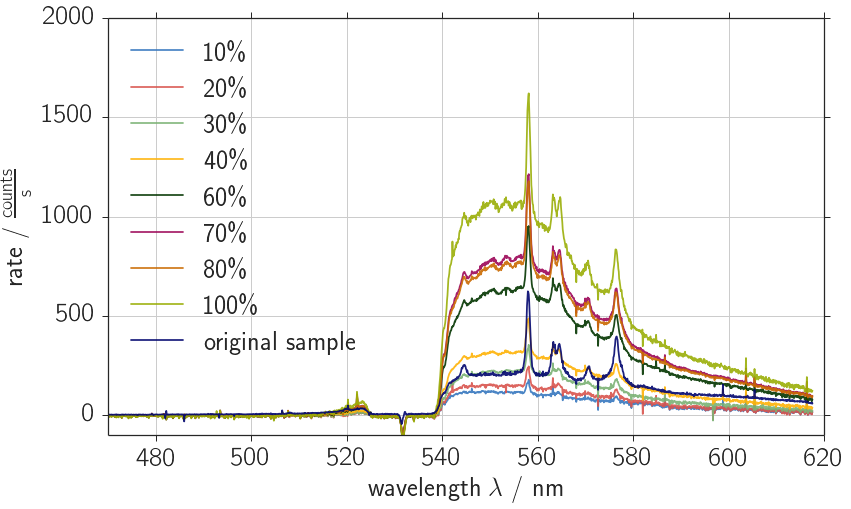

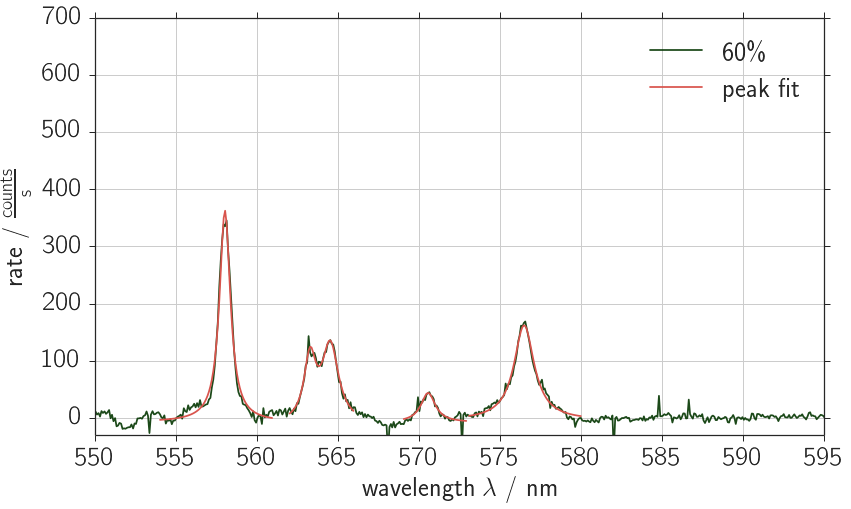

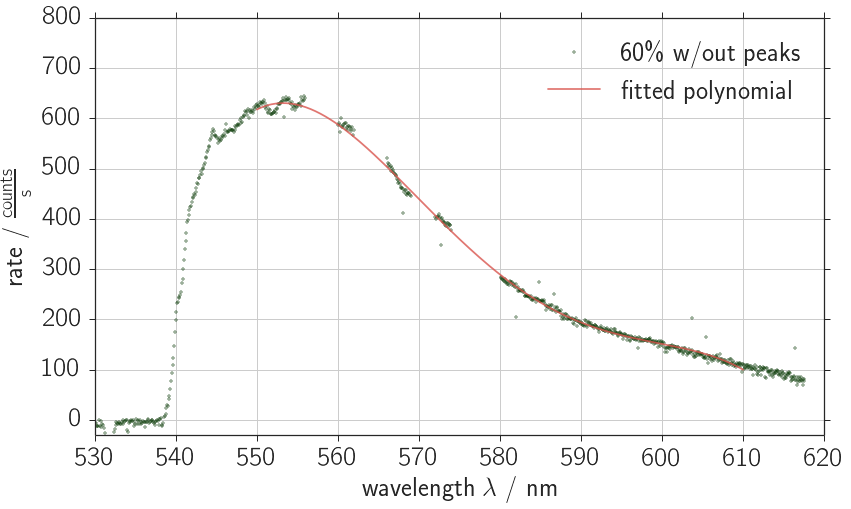

In [16]:
# ETHANOL

As = []   
x0s = []
two_x0 = []
concentration = [10, 20, 30, 40, 60, 70, 80, 100, 'orig']
labels = [str(conc) + r'\%' for conc in [10, 20, 30, 40, 60, 70, 80, 100]]  + ['original sample']
corr = np.load(npy_dir + 'ccd_corr0.npy') # Correction factor for polarization

# Plotting
print('Calculate ethanol')
fig, ax = plt.subplots(1,1)
if not save_fig:
    fig.suptitle('CCD: Ethanol-H$_2$O spectra')   
fig2, ax2 = plt.subplots(1,1)
if not save_fig:
    fig2.suptitle('CCD: Ethanol peak fits')
for i, conc_i, label in enum(concentration, labels):
    print(str(conc_i) + '% ethanol')
    filename = "ccd_et_" + str(conc_i)
    t, avg, x, y, y_e = get_ccd_rate(filename)
    # Correction for polarization
    y = corr * y
    y_e = corr * y_e
    
    # Remove outliers 
    # identified by largest absolute value of difference between point and its two neighbours.
    for j in range(4):
        out = np.argmax(abs(2 * y[1:-1] - y[:-2] - y[2:])) + 1
        x, y = np.delete([x, y], out, 1)
        y_e = np.delete(y_e, out)
    ax.plot(x, y, "-", alpha = 0.9, c=colors[i], label=label)

    # Flourescence: fit for 550 - 590 nm w/out peaks
    x_peaks = np.array([[556, 560], [562, 566], [569, 572], [574, 580]])
    where_peaks = [(x_low < x) * (x < x_high) for x_low, x_high in x_peaks]
    mask_no_peak = np.where(sum(where_peaks) == 0)[0]
    x_np = x[mask_no_peak]
    y_np = y[mask_no_peak]
    y_np_e = y_e[mask_no_peak]
  
    x_range_poly = [550,  610]
    p0 = np.array([0, 0, 0, 0, 0])
    p =  poly_fit(x_np, y_np_e, x_range_poly, p0)
    p_n = un.nominal_values(p)
    x_poly = np.linspace(x_range_poly[0], x_range_poly[1], 200)
    y_poly = poly(x_poly, *p_n)

    # Peak fit: Data - flourescence
    y_fit = y - poly(x, *p_n)
    y_fit_e = y_e - poly(x, *p)

    if conc_i == 60:
        ax2.plot(x, y_fit, "-", c=colors[i], alpha = 0.9, label=(str(conc_i) + '\%'))
        
    # Peak fit
    # Peaks: Stokes 2,3, Anti-Stokes 2
    x_ranges = [[554, 561],
                [569, 573], 
                [573, 580]]
    p0s = np.array([[558, 0.2, 100, 0],
                    [571, 0.2, 50, 0], 
                    [577, 0.2, 50, 0]])

    for j, x_range, p0 in enum(x_ranges, p0s):
        x_fit, fit_peak, c1 = bw_fit(x, y_fit_e, x_range, p0, fit=True)
        As.append(c1[2])
        x0s.append(c1[0])
        if conc_i == 60:
                if j==0:
                    ax2.plot(x_fit, fit_peak, "-", c=colors[1], label='peak fit')
                else:
                    ax2.plot(x_fit, fit_peak, "-", c=colors[1])
    
    # double peak
    x_range_two = [562, 566]
    p0_two = np.array([563, 0.2, 100, 565, 0.2, 100, 0])
    x_fit2, fit_peak2, c2 = two_bw_fit(x, y_fit_e, x_range_two, p0_two, fit=True)
    x0s.append(c2[0])
    x0s.append(c2[3])
    As.append(c2[2])
    As.append(c2[5])
    if conc_i == 60:
        ax2.plot(x_fit2, fit_peak2, "-", c=colors[1])

    if conc_i == 60:        
        fig3, ax3 = plt.subplots(1,1)
        if not save_fig:
            fig3.suptitle('CCD: Ethanol Flourescence, Concentration: ' + str(conc_i) + '\%' )
        ax3.plot(x_np, y_np, ".", c=colors[i], alpha = 0.4, label=(str(conc_i) + '\% w/out peaks'))  
        ax3.plot(x_poly, y_poly, "-", c=colors[1], alpha = 0.8, label='fitted polynomial')
        ax3.set_xlim(x_range_poly[0] - 20, 620)
        ax3.set_ylim(-30, 800)
        ax3.set_xlabel('wavelength $\lambda$ / nm')
        ax3.set_ylabel('rate / $\mathrm{\\frac{counts}{s}}$')
        ax3.grid(True)
        ax3.legend(loc='best')


ax.set_xlim(470, 620)
ax.set_ylim(-100, 2000)
ax.set_xlabel('wavelength $\lambda$ / nm')
ax.set_ylabel('rate / $\mathrm{\\frac{counts}{s}}$')
ax.grid(True)
ax.legend(loc='best')

ax2.set_xlim(x_range_poly[0], x_range_poly[1] - 15)
ax2.set_ylim(-30, 700)
ax2.set_xlabel('wavelength $\lambda$ / nm')
ax2.set_ylabel('rate / $\mathrm{\\frac{counts}{s}}$')
ax2.grid(True)
ax2.legend(loc='best')

if save_fig:
    file_name = "ccd_ethanol_spectra"
    fig.savefig(fig_dir + file_name + ".pdf")
    fig.savefig(fig_dir + file_name + ".png")
    file_name = "ccd_ethanol_peak_fits"
    fig2.savefig(fig_dir + file_name + ".pdf")
    fig2.savefig(fig_dir + file_name + ".png")
    file_name = "ccd_ethanol_fluorescence"
    fig3.savefig(fig_dir + file_name + ".pdf")
    fig3.savefig(fig_dir + file_name + ".png")

/usr/lib/python3/dist-packages/matplotlib/figure.py:372: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/usr/lib/python3/dist-packages/matplotlib/figure.py:1596: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


\cellcolor{LightCyan}$1$ & $558.241 \pm 0.003$ & $880 \pm 11$ & $888$ & $72 \pm 2$  \\
\cellcolor{LightCyan}$2$ & $563.476 \pm 0.003$ & $1047 \pm 11$ & $1028$ & $80 \pm 2$  \\
\cellcolor{LightCyan}$3$ & $564.691 \pm 0.004$ & $1085 \pm 11$ & $1091$ & $74 \pm 2$  \\
\cellcolor{LightCyan}$4$ & $570.774 \pm 0.006$ & $1274 \pm 11$ & $1274$ & $79 \pm 3$  \\
\cellcolor{LightCyan}$5$ & $576.699 \pm 0.003$ & $1454 \pm 11$ & $1464$ & $73 \pm 2$  \\

 Ethanol concentration of unknown sample:  75.7 \pm 1.0
Standard deviation:  3.41569941695


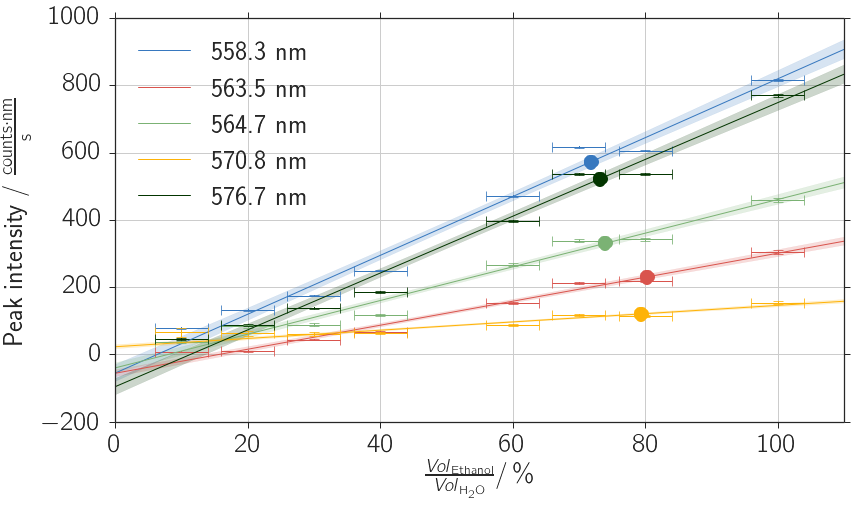

In [18]:
# Linear fit on ethanol percentage

from scipy.odr import ODR, Model, Data, RealData

def func(beta, x):
    y = beta[0] + beta[1] * x
    return y

def linear_beta(x, beta_0, beta_1):
    return beta_0 + beta_1 * x

# Plotting
x_min, x_max = [0, 110]
x_fit = np.linspace(x_min, x_max, 200)
fig, ax = plt.subplots(1, 1)
if not save_fig:
    fig.suptitle('CCD: Intensity of peaks over ethanol concentration', y = 1.02)

intensity = np.array(As).reshape(9, 5).T[[0, 3, 4, 1, 2]].T # move peak 2 & 3 to the correct position    
A_lambda = intensity[:-1].T # entries of each peak put together
peaks = ['558.3', '563.5', '564.7', '570.8', '576.7']
intersects = []

x = np.array(concentration[:-1])
sx = 4
for i, peak, A in enum(peaks, A_lambda):
    y = un.nominal_values(A)
    sy = un.std_devs(A)


    data = RealData(x, y, sx=sx, sy=sy)
    model = Model(func)

    odr = ODR(data, model, [6, 0])
    odr.set_job(fit_type=0)
    output = odr.run()

    beta = uc.correlated_values(output.beta, output.cov_beta)
    
    fit = linear_beta(x_fit, *beta)

    ax.fill_between(x_fit, 
            un.nominal_values(fit) + un.std_devs(fit),
            un.nominal_values(fit) - un.std_devs(fit),
            facecolor=colors[i], color=colors[i], alpha=0.2)
    ax.plot(x_fit, un.nominal_values(fit), '-', c=colors[i], linewidth=1.0, label=peak + ' nm')  
    ax.errorbar(x, y, xerr=sx, yerr=sy, fmt=',', c=colors[i], elinewidth=1.0, capsize=5.2, capthick=0.8)
    
    #Intersects
    y0 = intensity[-1][i] # peak intensities of the original sample
    x0 = (y0 - beta[0]) / beta[1]
    intersects.append(x0)
    #ax.plot([x_min, x_max], [As[-1][i].n]*2, '--', c=colors[i]) # plot line
    ax.plot(x0.n, y0.n, 'o', c=colors[i], ms=15) # plot only intersect
    
ax.set_xlim(0, 110)
ax.set_xlabel("$\\frac{Vol_\mathrm{\,Ethanol}}{Vol_\mathrm{\,H_2O}} / \,\% $")
ax.set_ylabel("Peak intensity / $\mathrm{\\frac{counts \cdot nm}{s}}$")
ax.grid(True)
ax.legend(loc='best')

if show_fig:
    fig.show()
if save_fig:
    file_name = "ccd_ethanol_intensity"
    fig.savefig(fig_dir + file_name + ".pdf")
    fig.savefig(fig_dir + file_name + ".png")
    
# Print Latex table
lamb_all = np.array(x0s).reshape(9, 5)

d_lin = np.load(npy_dir + 'ccd_calibration.npy') 
lamb_all = linear(lamb_all, *d_lin) # Integrate error on wavelength of CCD

lamb_mean = np.mean(lamb_all, 0) 
lamb_laser = np.load(npy_dir + 'ccd_lamb_laser.npy')[0]

dnu = (1 / lamb_mean - 1 / lamb_laser) * 10**7

lamb_mean = np.sort(lamb_mean)
lits = np.array([888, 1028, 1091, 1274, 1464]) 

for i, x0, dnu_cm, lit,intersect in enum(lamb_mean, lamb_to_cm(lamb_mean), lits, intersects):
    print("\cellcolor{LightCyan}$%i$ & $%s$ & $%s$ & $%s$ & $%s$  \\\\"%(
            i+1, uc_str(x0), uc_str(dnu_cm), lit, uc_str(intersect)))
    
# Ethanol concentration in the unknown original sample.
print('\n Ethanol concentration of unknown sample: ', uc_str(np.mean(intersects)))
print('Standard deviation: ', np.std(un.nominal_values(intersects)))

## Sulfur -- Temperature
* Get data
* Fit Stokes and Anti-Stokes peak for each laser intensity.
* Notch filter is plotted in order to see its influence.

#### The intensity is supposed to follow the relationship

$\frac{I_{AS}}{I_{S}}  = \left( \frac{\nu_L + \Delta \nu}{\nu_L - \Delta \nu} \right)^4 e^{-\frac{h \Delta \nu}{k_B T}}$

and should thus be constant for all intensities (ignoring warming due to the laser...). We take the mean value of all measured ones.

Get Laser wavelength, Raman peak wavelength!

Calculate temperature
0.70 A
0.80 A
0.90 A
1.00 A
1.10 A
1.20 A
1.30 A
1.40 A
1.50 A


/usr/lib/python3/dist-packages/matplotlib/figure.py:1596: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


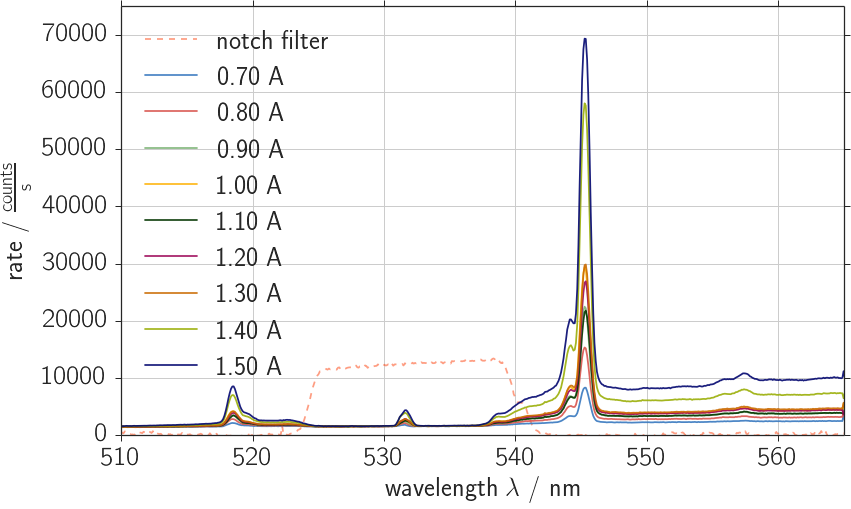

In [19]:
corr = np.load(npy_dir + 'ccd_corr0.npy') # Correction factor for polarization
rate_bg = np.load(npy_dir + 'ccd_rate_bg.npy')
rate_bg_e = np.load(npy_dir + 'ccd_rate_bg_e.npy')

# Plotting
fig, ax = plt.subplots(1,1)
if not save_fig:
    fig.suptitle('CCD: Sulfur spectra')
    
I_laser_all = [70, 80, 90, 100, 110, 120, 130, 140, 150]
labels = ['%.2f A'%(I_l * 0.01) for I_l in I_laser_all]
#I_laser_all = [130]
    
# display notch filter in order to identify its effects
x_notch = np.load("npy/ccd_x_notch.npy")
notch = np.load("npy/ccd_notch.npy")
ax.plot(x_notch, notch * 0.3, "--", c=colors[-1], alpha = 0.5, label='notch filter')

x0s = []
As = []
print('Calculate temperature')
for i, I_laser, label in enum(I_laser_all, labels):
    print(label)
    filename = "ccd_s_" + str(I_laser).zfill(3)
    t, avg, x, y, y_e = get_ccd_rate(filename)
    # Correction for polarization
    y = corr * y
    y_e = corr * y_e
    ax.plot(x, y, "-", alpha = 0.9, c=colors[i], label=label)
    
    x_ranges = [[545, 549],
                [510, 519]]
    p0s = np.array([[545.5, 0.2, 20000, 3500],
                    [518, 0.2, 5000, 200]])

    for j, x_range, p0 in enum(x_ranges, p0s):
        x_fit, fit_peak, c1 = bw_fit(x, y_e, x_range, p0, fit=True)
        x0s.append(c1[0])
        As.append(c1[2])

ax.set_xlim(xlim_global)
ax.set_xlim(510, 565)
ax.set_ylim(0, 75000)
ax.set_xlabel('wavelength $\lambda$ / nm')
ax.set_ylabel('rate / $\mathrm{\\frac{counts}{s}}$')
ax.grid(True)
ax.legend(loc='best')

if save_fig:
    file_name = "ccd_sulfur_spectra"
    fig.savefig(fig_dir + file_name + ".pdf")
    fig.savefig(fig_dir + file_name + ".png")

\cellcolor{LightCyan}$0.70$ A & $7462 \pm 6$ & $1096 \pm 5$ & $0.1468 \pm 0.0006$   \\
\cellcolor{LightCyan}$0.80$ A & $15187 \pm 7$ & $2004 \pm 4$ & $0.1320 \pm 0.0003$   \\
\cellcolor{LightCyan}$0.90$ A & $22940 \pm 8$ & $2952 \pm 4$ & $0.1287 \pm 0.0002$   \\
\cellcolor{LightCyan}$1.00$ A & $30256 \pm 8$ & $3834 \pm 4$ & $0.1267 \pm 0.0002$   \\
\cellcolor{LightCyan}$1.10$ A & $22607 \pm 7$ & $2866 \pm 5$ & $0.1268 \pm 0.0002$   \\
\cellcolor{LightCyan}$1.20$ A & $28225 \pm 8$ & $3552 \pm 5$ & $0.1259 \pm 0.0002$   \\
\cellcolor{LightCyan}$1.30$ A & $31637 \pm 8$ & $3939 \pm 5$ & $0.1245 \pm 0.0002$   \\
\cellcolor{LightCyan}$1.40$ A & $62397 \pm 9$ & $7582 \pm 5$ & $0.12151 \pm 0.00008$   \\
\cellcolor{LightCyan}$1.50$ A & $77655 \pm 10$ & $9649 \pm 5$ & $0.12425 \pm 0.00007$   \\


Mean intensity ratio:  0.129 \pm 0.007

 Wavenumbers of both peaks:
\cellcolor{LightCyan}$1$ & $545.542 \pm 0.002$ & $463 \pm 11$ & $bla$   \\
\cellcolor{LightCyan}$2$ & $518.785 \pm 0.002$ & $482 \pm 1

/usr/lib/python3/dist-packages/matplotlib/figure.py:1596: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


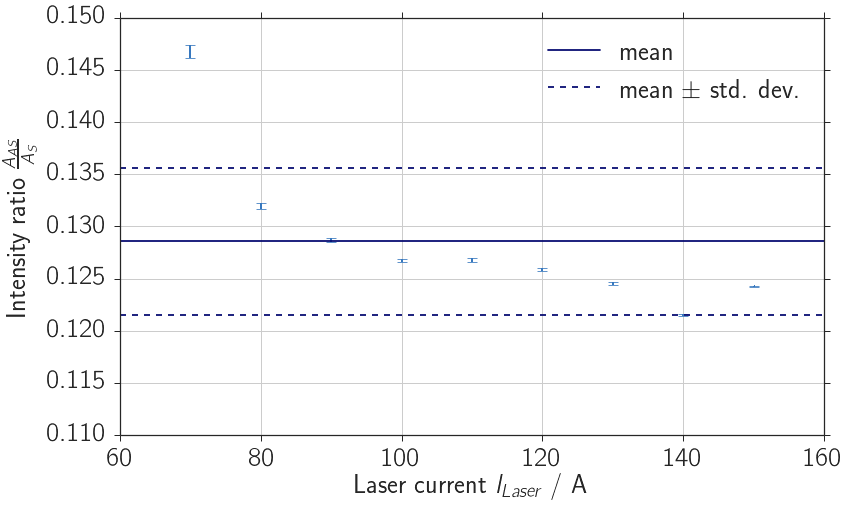

In [20]:
intensities = np.array(As).reshape(9, 2).T # stokes and anti-stokes
A_ratio = intensities[1] / intensities[0]
y = un.nominal_values(A_ratio)
sy = un.std_devs(A_ratio)

mean_ratio = np.mean(y)
std_ratio = np.std(y)
mean_ratio_e = uc.ufloat(mean_ratio, std_ratio)

fig, ax = plt.subplots(1,1)
if not save_fig:
    fig.suptitle('CCD: Ratio of intensities of Stokes and AS peaks (sulfur)')

ax.errorbar(I_laser_all, y, xerr=None, yerr=sy, fmt=',', c=colors[0], 
            elinewidth=2.0, capsize=5.2, capthick=0.8)
ax.plot([60, 160], [mean_ratio]*2, '-', c=colors[8], label='mean')
ax.plot([60, 160], [mean_ratio - std_ratio]*2, '--', c=colors[8], label='mean $\pm$ std. dev.')
ax.plot([60, 160], [mean_ratio + std_ratio]*2, '--', c=colors[8])

ax.set_xlim(60, 160)
ax.set_ylim(0.11, 0.15)
ax.set_xlabel('Laser current $I_{Laser}$ / A')
ax.set_ylabel('Intensity ratio $\\frac{A_{AS}}{A_{S}}$')
ax.grid(True)
ax.legend(loc='best')

if save_fig:
    file_name = "ccd_temp_rate"
    fig.savefig(fig_dir + file_name + ".pdf")
    fig.savefig(fig_dir + file_name + ".png")

# Print latex table
for I_l, Is, Ias, A_rat in zip(labels, intensities[0], intensities[1], A_ratio):
    print("\cellcolor{LightCyan}$%s$ A & $%s$ & $%s$ & $%s$   \\\\"%(
            I_l[:-2], uc_str(Is), uc_str(Ias), uc_str(A_rat, 5)))

print('\n')
print('Mean intensity ratio: ', uc_str(uc.ufloat(mean_ratio, std_ratio)))


# Print latex table of wavenumbers
lamb_all = np.array(x0s).reshape(9, 2)

d_lin = np.load(npy_dir + 'ccd_calibration.npy') 
lamb_all = linear(lamb_all, *d_lin) # Integrate error on wavelength of CCD

lamb_mean = np.mean(lamb_all, 0) 
lamb_laser = np.load(npy_dir + 'ccd_lamb_laser.npy')[0]

dnu = (1 / lamb_mean - 1 / lamb_laser) * 10**7

lits = np.array(['bla', 'blub']) # S, S, S, AS, AS for CCl4

print('\n Wavenumbers of both peaks:')
for i, x0, dnu_cm, lit in enum(lamb_mean, lamb_to_cm(lamb_mean), lits):
    print("\cellcolor{LightCyan}$%i$ & $%s$ & $%s$ & $%s$   \\\\"%(
            i+1, uc_str(x0), uc_str(dnu_cm), lit))
    
# Calculation of temperature (uses SI units!)
from scipy.constants import k, c, h
nu_l_si = c / lamb_laser
dnu_si = np.mean(abs(c / lamb_mean - nu_l_si)) # in Hz!!!
T = -(h * dnu_si * 10**9) / (k * un.log(mean_ratio_e * ((nu_l_si - dnu_si) / (nu_l_si + dnu_si))**4))
print('\n\Delta \\nu = ' + uc_str(dnu_si * 10**-2) + ' Hz')
print('Temperatur T = ' + uc_str(T) + ' K')
print('Temperatur T = ' + uc_str(T - 273.15) + ' ^\circ C')